In [ ]:
# Libraries required

In [114]:
import yfinance as yf
import pandas as pd
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from pygooglenews import GoogleNews
import json
import time
import talib
import pandas_ta as ta

In [88]:
# Selection of the stock for predictive strategy and date range

stock = 'LLOY.L'
start_date = "2015-01-01"
end_date = "2024-10-31"

# Download historical data using yfinance

data = yf.download(stock, start=start_date, end=end_date)

# Print data for quick inspection

data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,76.470001,76.750000,75.668999,76.150002,53.592781,54277932
2015-01-05,76.070000,76.400002,74.459999,74.620003,52.516003,102525515
2015-01-06,74.629997,75.050003,72.870003,72.870003,51.284382,133810250
2015-01-07,73.320000,73.943001,72.870003,73.010002,51.382904,108980419
2015-01-08,73.510002,74.419998,73.250000,74.099998,52.150024,79367070
...,...,...,...,...,...,...
2024-10-24,61.900002,62.619999,61.700001,62.200001,62.200001,263067192
2024-10-25,62.380001,62.520000,57.580002,57.660000,57.660000,312290651
2024-10-28,56.599998,57.500000,55.480000,56.119999,56.119999,302863589


Following data normalization was done but then left as it does not have much of an effect on the model of choice

In [ ]:
# We use forward fill to remove any missing data
data.fillna(method="ffill", inplace=True)

# Data is then normalised for a few reasons:
# - to normalise the scales of the vastly different data, so no single feature is vastly greater
# - converegence for example with gradient descent will be quicker with features of similar scales
# - avoids bias towards high-magnitude numbers
# - required for distance based models such as K-NN and SVM
# - 
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

print(data_scaled.head())

In [102]:
# Google news articles retrieved related to share

gn = GoogleNews()
search_results = gn.search('lloyds')

entries = search_results["entries"]

# Lists to store extracted data
titles = []
dates = []

# Loop through each entry and extract title and published date
for entry in entries:
    titles.append(entry["title"])
    dates.append(entry["published"])
    time.sleep(0.25)  # To avoid getting rate-limited

# Create a pandas dataframe
df = pd.DataFrame({
    "Title": titles,
    "Date": dates
})

,Title,Date
0,Lloyd’s targeting 11% premium growth in 2025 -...,2024-11-29 17:52:59+00:00
1,Re/insurance market sufficiently balanced to r...,2024-11-29 15:19:40+00:00
2,Lloyds Banking Updates Shareholders on Voting ...,2024-11-29 15:15:17+00:00
3,‘We cannot accept passivity’ on cycle manageme...,2024-11-29 15:10:06+00:00
4,Lloyd's will bear down on delegated authority ...,2024-11-29 14:59:00+00:00
...,...,...
92,LR-RU-012 Classification of Ships using Gases ...,2024-07-01 07:00:00+00:00
93,Lloyd Ray Gehman Obituary 2024 - Naugle Funera...,2024-06-17 07:00:00+00:00
94,Capital Markets Day 2024 - Lloyd's List,2024-06-12 15:54:53+00:00
95,Activists disrupt Lloyds Bank shareholder meet...,2024-05-16 07:00:00+00:00


In [104]:
# Convert the Date column to a readable datetime format
df["Date"] = pd.to_datetime(df["Date"], utc=True)

# Sort the dataframe by Date
df = df.sort_values(by="Date", ascending=False).reset_index(drop=True)

# Print
df

,Title,Date
0,Lloyd’s targeting 11% premium growth in 2025 -...,2024-11-29 17:52:59+00:00
1,Re/insurance market sufficiently balanced to r...,2024-11-29 15:19:40+00:00
2,Lloyds Banking Updates Shareholders on Voting ...,2024-11-29 15:15:17+00:00
3,‘We cannot accept passivity’ on cycle manageme...,2024-11-29 15:10:06+00:00
4,Lloyd's will bear down on delegated authority ...,2024-11-29 14:59:00+00:00
...,...,...
92,LR-RU-012 Classification of Ships using Gases ...,2024-07-01 07:00:00+00:00
93,Lloyd Ray Gehman Obituary 2024 - Naugle Funera...,2024-06-17 07:00:00+00:00
94,Capital Markets Day 2024 - Lloyd's List,2024-06-12 15:54:53+00:00
95,Activists disrupt Lloyds Bank shareholder meet...,2024-05-16 07:00:00+00:00


In [ ]:
# Gathering Alternative data such as news articles using NLP models such as
# FinBERT an NLP model pretrained for financial text sentiment

sentiment_analysis = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

# Analyze sentiment and convert it into a score between 0 and 1
def get_sentiment_score(text):
    result = sentiment_analysis(text)[0]
    # Assign scores: POSITIVE -> confidence score, NEGATIVE -> 1 - confidence score
    score = result['score'] if result['label'] == 'POSITIVE' else 1 - result['score']
    return score

In [108]:
df["Sentiment"] = df["Title"].apply(lambda x: sentiment_analysis(x)[0]['label'])

In [ ]:
# Apply the function to the Title column
df["Sentiment_Score"] = df["Title"].apply(get_sentiment_score)

In [132]:
# Ensure the Date column is in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Extract the date (without time) for grouping
df["DateOnly"] = df["Date"].dt.date

# Group by the date and calculate the average sentiment score
daily_avg_sentiment = df.groupby("DateOnly")["Sentiment_Score"].mean().reset_index()

# Rename columns for clarity
daily_avg_sentiment.columns = ["Date", "Average_Sentiment_Score"]

# Display the new DataFrame
print(daily_avg_sentiment)

          Date  Average_Sentiment_Score
0   2024-04-24             5.306197e-01
1   2024-05-16             1.253843e-03
2   2024-06-12             1.299381e-05
3   2024-06-17             5.579591e-04
4   2024-07-01             4.768372e-06
5   2024-07-18             1.977086e-04
6   2024-07-25             9.416938e-04
7   2024-07-28             0.000000e+00
8   2024-08-08             1.800060e-05
9   2024-08-15             3.242493e-05
10  2024-08-29             5.987883e-04
11  2024-09-02             1.847744e-05
12  2024-09-06             9.655952e-06
13  2024-09-09             5.626678e-05
14  2024-09-21             8.106232e-06
15  2024-10-04             4.932181e-01
16  2024-10-08             2.563000e-05
17  2024-10-12             8.073449e-04
18  2024-10-13             3.442138e-01
19  2024-10-16             1.454353e-05
20  2024-10-18             6.008148e-04
21  2024-10-23             2.765656e-05
22  2024-10-25             2.264977e-05
23  2024-10-28             1.242558e-04


### Feature Engineering

Use technical indicators such as Smooth Moving Average, which averages the price of the last 20 days and the Relative Strength Indicator (RSI), a momentum indicator measuring the magnitude/pace of price changes.

In [174]:
# Moving Average
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

# Display the new features
print(data[['Close', 'SMA_20', 'RSI']].tail())

          Close  SMA_20        RSI
2477  62.200001  59.946  73.224031
2478  57.660000  59.859  43.478265
2479  56.119999  59.725  41.186169
2480  54.540001  59.542  31.554160
2481  53.660000  59.342  28.464991


In [266]:
# Addition of more technical indicators gathered using libraries TALib and pandas-ta

# MACD calculation
data['MACD'], data['Signal_Line'], data['MACD_Histogram'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands calculation
data['Upper_Band'], data['Middle_Band'], data['Lower_Band'] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2)

# ATR calculation
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)

# OBV calculation
data['OBV'] = talib.OBV(data['Close'], data['Volume'])

# Stochastic Oscillator calculation
data['SlowK'], data['SlowD'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=14, slowk_period=3, slowd_period=3)

# VWAP calculation
data['VWAP'] = (data['Volume'] * data['Close']).cumsum() / data['Volume'].cumsum()

In [270]:
# Ichimoku claculation
data.ta.ichimoku(append=True)

(          ISA_9     ISB_26      ITS_9     IKS_26     ICS_26
 1           NaN        NaN        NaN        NaN  80.370003
 2           NaN        NaN        NaN        NaN  78.750000
 3           NaN        NaN        NaN        NaN  78.160004
 4           NaN        NaN        NaN        NaN  79.199997
 5           NaN        NaN        NaN        NaN  79.000000
 ...         ...        ...        ...        ...        ...
 2458  55.577500  56.049999  61.384501  60.184502        NaN
 2459  55.577500  56.049999  60.524502  60.184502        NaN
 2460  55.980000  56.049999  59.474501  59.474501        NaN
 2461  57.906000  56.049999  58.872002  58.872002        NaN
 2462  58.190001  56.049999  58.319000  58.319000        NaN
 
 [2462 rows x 5 columns],
           ISA_9     ISB_26
 2463  58.290000  56.049999
 2464  58.305000  56.049999
 2465  58.315001  56.049999
 2466  58.315001  56.049999
 2467  58.320001  56.049999
 2468  58.265000  56.049999
 2469  58.125001  56.049999
 2470  58.125001

Merged sentiment score with features - due to a limited list of news articles thus sentiment scores a model was created but did not fruit strong results since limited data

In [278]:
# Ensure daily_avg_sentiment['Date'] is in datetime format
daily_avg_sentiment['Date'] = pd.to_datetime(daily_avg_sentiment['Date'])

# Reset the index for 'data' temporarily and ensure its index is in datetime format
data = data.reset_index()  # This moves the 'Date' index to a column
data['Date'] = pd.to_datetime(data['Date'])

# Merge on 'Date'
merged_df = pd.merge(data[['Date', 'Close', 'SMA_20', 'RSI', 'Open', 'High', 'Low', 'Volume']], 
                     daily_avg_sentiment, 
                     on='Date', 
                     how='inner')

# If needed, set 'Date' back as the index
merged_df.set_index('Date', inplace=True)

# Display the last rows of the merged DataFrame
print(merged_df.tail())

                Close  SMA_20        RSI       Open       High        Low  \
Date                                                                        
2024-10-23  61.619999  59.785  62.879071  63.000000  63.469002  60.820000   
2024-10-25  57.660000  59.859  40.031616  62.380001  62.520000  57.580002   
2024-10-28  56.119999  59.725  35.031576  56.599998  57.500000  55.480000   
2024-10-29  54.540001  59.542  30.783360  56.279999  56.380001  54.275002   
2024-10-30  53.660000  59.342  28.696080  53.759998  55.090000  53.168999   

               Volume  Average_Sentiment_Score  
Date                                            
2024-10-23  213089101                 0.000028  
2024-10-25  312290651                 0.000023  
2024-10-28  302863589                 0.000124  
2024-10-29  239820524                 0.000997  
2024-10-30  305260035                 0.358854  


In [292]:
# Get all column names except the ones you don't want (e.g., 'Date', 'level_0', 'index')
exclude_columns = ['Date', 'level_0', 'index', 'Prediction', 'Cumulative_Strategy_Return', 'Cumulative_Market_Return', 'Close', 'Adj Close']

# Filter out the columns that are not needed for features
features = [col for col in data.columns if col not in exclude_columns]

features

['Open',
 'High',
 'Low',
 'Volume',
 'SMA_20',
 'RSI',
 'Strategy_Return',
 'MACD',
 'Signal_Line',
 'MACD_Histogram',
 'Upper_Band',
 'Middle_Band',
 'Lower_Band',
 'ATR',
 'OBV',
 'SlowK',
 'SlowD',
 'VWAP',
 'ISA_9',
 'ISB_26',
 'ITS_9',
 'IKS_26',
 'ICS_26']

Model created using all the technical indicators listed above

In [298]:
from sklearn.model_selection import train_test_split

data = data.dropna()

# Features and target
X = data[features].dropna()  # Features
y = (data['Adj Close'].shift(-1) > data['Adj Close']).astype(int).dropna()  # Binary target (price up or down)

# Align the target with features
X = X.dropna()
y = y.dropna()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (1887, 23), Testing set: (472, 23)


In [ ]:
# XGBClassifier model used 

In [300]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       261
           1       0.48      0.54      0.51       211

    accuracy                           0.54       472
   macro avg       0.54      0.54      0.53       472
weighted avg       0.54      0.54      0.54       472



Understanding the importance of each of the features used

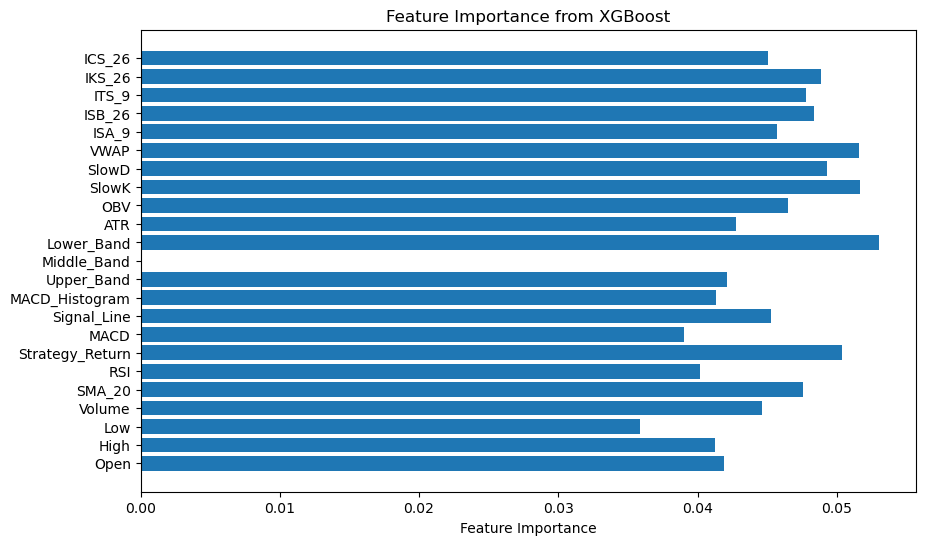

In [302]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance
importance = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("Feature Importance from XGBoost")
plt.show()

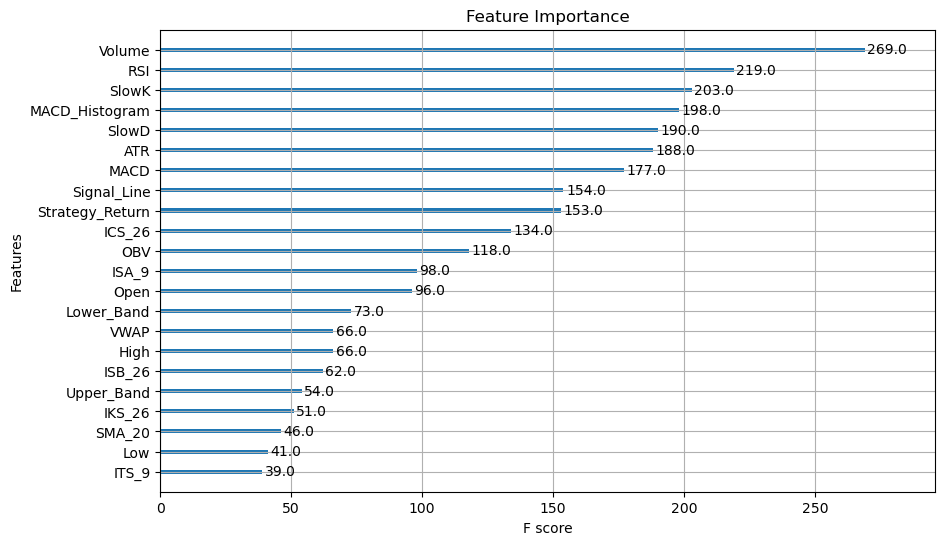

In [323]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', ax=ax)

plt.title("Feature Importance")
plt.show()

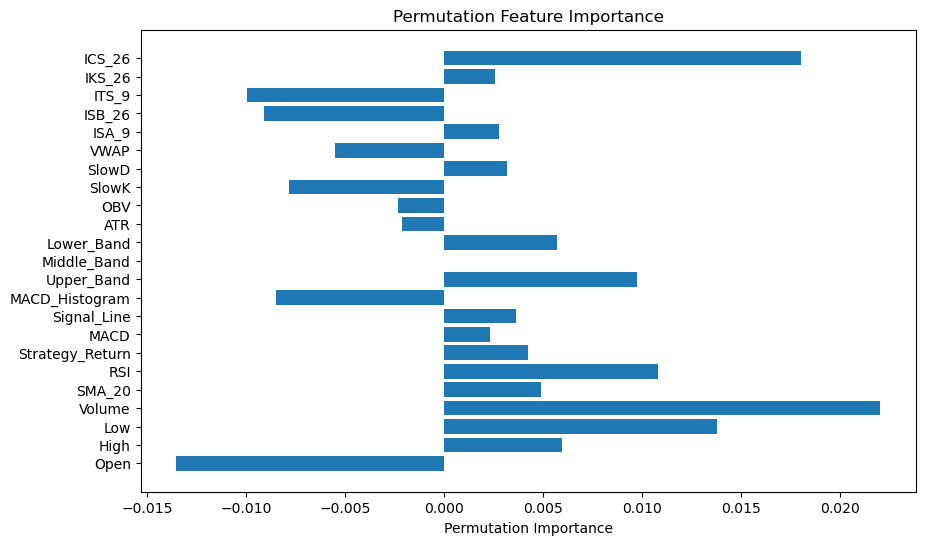

In [306]:
from sklearn.inspection import permutation_importance

# Get permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Extract the importance scores
importance = result.importances_mean

# Plot the importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.show()

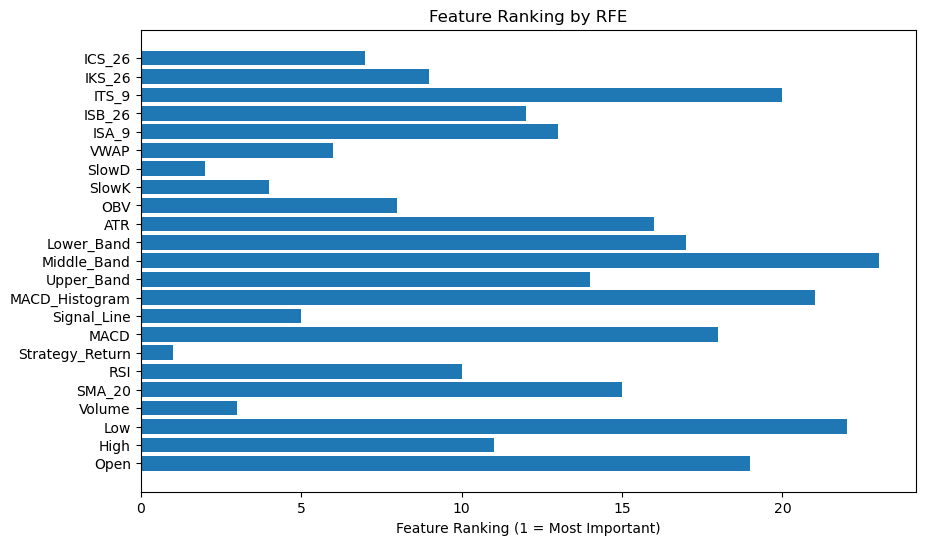

In [308]:
from sklearn.feature_selection import RFE

# RFE with XGBoost
selector = RFE(estimator=model, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)

# Get ranking of features
ranking = selector.ranking_

# Plot feature ranking
plt.figure(figsize=(10, 6))
plt.barh(features, ranking)
plt.xlabel("Feature Ranking (1 = Most Important)")
plt.title("Feature Ranking by RFE")
plt.show()

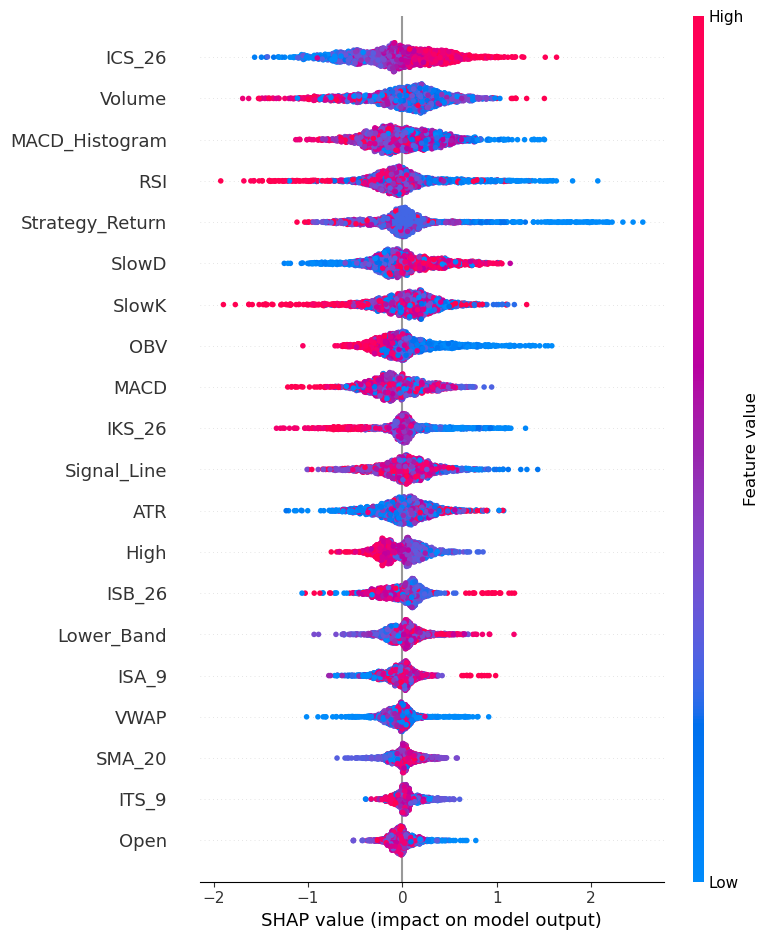

In [312]:
import shap

# Initialize the SHAP explainer for XGBoost
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot summary plot (global feature importance)
shap.summary_plot(shap_values, X_train)

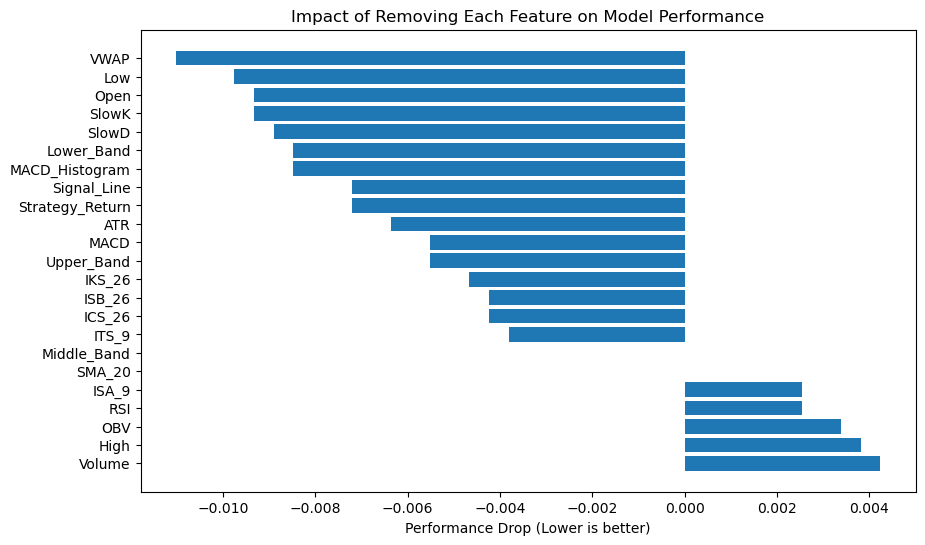

In [314]:
from sklearn.model_selection import cross_val_score

# Function to evaluate model performance by removing each feature
def evaluate_feature_subset(X, y, feature_subset):
    return cross_val_score(XGBClassifier(), X[feature_subset], y, cv=5, scoring='accuracy').mean()

# Evaluate model performance with all features
all_features_score = evaluate_feature_subset(X, y, features)

# Evaluate performance with each feature removed
feature_scores = {}
for feature in features:
    subset = [f for f in features if f != feature]
    score = evaluate_feature_subset(X, y, subset)
    feature_scores[feature] = all_features_score - score  # Performance drop when this feature is removed

# Sort features by their performance drop
sorted_feature_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Plot the drop in performance for each feature
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in sorted_feature_scores], [f[1] for f in sorted_feature_scores])
plt.xlabel("Performance Drop (Lower is better)")
plt.title("Impact of Removing Each Feature on Model Performance")
plt.show()

Simpler model using less feeatures

In [186]:
from sklearn.model_selection import train_test_split

data = data.dropna()

# Features and target
X = data[['SMA_20', 'RSI', 'Open', 'High', 'Low', 'Volume']].dropna()  # Features
y = (data['Adj Close'].shift(-1) > data['Adj Close']).astype(int).dropna()  # Binary target (price up or down)

# Align the target with features
X = X.dropna()
y = y.dropna()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (1970, 2), Testing set: (493, 2)


In [188]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       260
           1       0.46      0.45      0.46       233

    accuracy                           0.49       493
   macro avg       0.49      0.49      0.49       493
weighted avg       0.49      0.49      0.49       493



Model using the sentiment score as one of the features (small sample size due to limited number of articles)

In [ ]:
from sklearn.model_selection import train_test_split

data = data.dropna()

# Features and target
X = merged_df[['SMA_20', 'RSI', 'Open', 'High', 'Low', 'Volume', 'Average_Sentiment_Score']].dropna()  # Features
y = (merged_df['Close'].shift(-1) > merged_df['Close']).astype(int).dropna()  # Binary target (price up or down)

# Align the target with features
X = X.dropna()
y = y.dropna()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

In [258]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.29
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.00      0.00      0.00         3

    accuracy                           0.29         7
   macro avg       0.20      0.25      0.22         7
weighted avg       0.23      0.29      0.25         7

